Data Preparation

Import Libraries and load the MIMIC-III dataset and prepare for further processing.

In [11]:
# Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

In [2]:
def load_data(filepath, required_columns):
    data = pd.read_csv(filepath)
    data = data[required_columns]
    return data

def convert_datetime(data, column):
    return pd.to_datetime(data[column])

In [3]:
filepath1='mimic-iii-clinical-database-demo-1.4/PATIENTS.csv'
filepath2='mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv'
filepath3='mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv'

required_columns1=['subject_id', 'gender', 'dob', 'dod']
required_columns2=['subject_id', 'hadm_id', 'ethnicity', 'dischtime']
required_columns3=['subject_id', 'hadm_id', 'icustay_id', 'first_careunit', 'last_careunit', 'intime', 'outtime', 'los']

In [4]:
# Load the PATIENTS, ADMISSIONS, & ICUSTAYS data from MIMIC-III dataset 
data_patients = load_data(filepath1, required_columns1)
data_admissions = load_data(filepath2, required_columns2)
data_icustays = load_data(filepath3, required_columns3)

In [5]:
# Display basic information about the dataset
display(Markdown("#### Basic Information on PATIENTS"))
print(data_patients.shape)
print(data_patients.info())
print(data_patients.describe())

display(Markdown("#### Basic Information on ADMISSIONS"))
print(data_admissions.shape)
print(data_admissions.info())
print(data_admissions.describe())

display(Markdown("#### Basic Information on ICUSTAYS"))
print(data_icustays.shape)
print(data_icustays.info())
print(data_icustays.describe())

#### Basic Information on PATIENTS

(100, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  100 non-null    int64 
 1   gender      100 non-null    object
 2   dob         100 non-null    object
 3   dod         100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB
None
         subject_id
count    100.000000
mean   26162.330000
std    16201.834705
min    10006.000000
25%    10068.500000
50%    25128.000000
75%    42276.500000
max    44228.000000


#### Basic Information on ADMISSIONS

(129, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  129 non-null    int64 
 1   hadm_id     129 non-null    int64 
 2   ethnicity   129 non-null    object
 3   dischtime   129 non-null    object
dtypes: int64(2), object(2)
memory usage: 4.2+ KB
None
         subject_id        hadm_id
count    129.000000     129.000000
mean   28010.410853  152343.441860
std    16048.502883   27858.788248
min    10006.000000  100375.000000
25%    10088.000000  128293.000000
50%    40310.000000  157235.000000
75%    42135.000000  174739.000000
max    44228.000000  199395.000000


#### Basic Information on ICUSTAYS

(136, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      136 non-null    int64  
 1   hadm_id         136 non-null    int64  
 2   icustay_id      136 non-null    int64  
 3   first_careunit  136 non-null    object 
 4   last_careunit   136 non-null    object 
 5   intime          136 non-null    object 
 6   outtime         136 non-null    object 
 7   los             136 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 8.6+ KB
None
         subject_id        hadm_id     icustay_id         los
count    136.000000     136.000000     136.000000  136.000000
mean   28263.485294  153259.566176  250980.470588    4.452457
std    16008.281510   28054.220280   28455.125832    6.196828
min    10006.000000  100375.000000  201006.000000    0.105900
25%    10089.750000  129028.000000  224359.250000    1.23352

In [6]:
# Convert datetime columns
data_patients['dod'] = convert_datetime(data_patients, 'dod')
data_admissions['dischtime'] = convert_datetime(data_admissions, 'dischtime')
data_icustays['intime'] = convert_datetime(data_icustays, 'intime')
data_icustays['outtime'] = convert_datetime(data_icustays, 'outtime')

In [7]:
# Display the first few rows of datasets
display(Markdown("#### Display first few rows of data_patients"))
print(data_patients.head())
display(Markdown("#### Display first few rows of data_admissions"))
print(data_admissions.head())
display(Markdown("#### Display first few rows of data_icustays"))
print(data_icustays.head())

#### Display first few rows of data_patients

   subject_id gender                  dob        dod
0       10006      F  2094-03-05 00:00:00 2165-08-12
1       10011      F  2090-06-05 00:00:00 2126-08-28
2       10013      F  2038-09-03 00:00:00 2125-10-07
3       10017      F  2075-09-21 00:00:00 2152-09-12
4       10019      M  2114-06-20 00:00:00 2163-05-15


#### Display first few rows of data_admissions

   subject_id  hadm_id               ethnicity           dischtime
0       10006   142345  BLACK/AFRICAN AMERICAN 2164-11-01 17:15:00
1       10011   105331   UNKNOWN/NOT SPECIFIED 2126-08-28 18:59:00
2       10013   165520   UNKNOWN/NOT SPECIFIED 2125-10-07 15:13:00
3       10017   199207                   WHITE 2149-06-03 18:42:00
4       10019   177759                   WHITE 2163-05-15 12:00:00


#### Display first few rows of data_icustays

   subject_id  hadm_id  icustay_id first_careunit last_careunit  \
0       10006   142345      206504           MICU          MICU   
1       10011   105331      232110           MICU          MICU   
2       10013   165520      264446           MICU          MICU   
3       10017   199207      204881            CCU           CCU   
4       10019   177759      228977           MICU          MICU   

               intime             outtime      los  
0 2164-10-23 21:10:15 2164-10-25 12:21:07   1.6325  
1 2126-08-14 22:34:00 2126-08-28 18:59:00  13.8507  
2 2125-10-04 23:38:00 2125-10-07 15:13:52   2.6499  
3 2149-05-29 18:52:29 2149-05-31 22:19:17   2.1436  
4 2163-05-14 20:43:56 2163-05-16 03:47:04   1.2938  


In [8]:
# Merge ICUSTAYS with ADMISSIONS on subject_id and hadm_id
merged_df = data_icustays.merge(data_admissions[['subject_id', 'hadm_id', 'dischtime']], on=['subject_id', 'hadm_id'], how='left')

# Merge with PATIENTS on subject_id to get date of death (dod)
merged_df = merged_df.merge(data_patients[['subject_id', 'gender', 'dod']], on='subject_id', how='left')

In [9]:
# Display basic information about the dataset
display(Markdown("#### Basic Information on merged data"))
print(merged_df.info())
print(merged_df.describe())

#### Basic Information on merged data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      136 non-null    int64         
 1   hadm_id         136 non-null    int64         
 2   icustay_id      136 non-null    int64         
 3   first_careunit  136 non-null    object        
 4   last_careunit   136 non-null    object        
 5   intime          136 non-null    datetime64[ns]
 6   outtime         136 non-null    datetime64[ns]
 7   los             136 non-null    float64       
 8   dischtime       136 non-null    datetime64[ns]
 9   gender          136 non-null    object        
 10  dod             136 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(3), object(3)
memory usage: 11.8+ KB
None
         subject_id        hadm_id     icustay_id  \
count    136.000000     136.000000     136.000000   
mean   28263.485294  15325

In [10]:
# Define survival status
"""
Survival status: 1 if the patient died within the ICU stay, 0 otherwise
Note: Patients who have a dod and it is before or equal to outtime are considered non-survivors
"""
merged_df['survival'] = ((merged_df['dod'].isna()) | (merged_df['dod'] > merged_df['outtime'])).astype(int)

Clean and Preprocess the Data

We shall clean and preprocess the MIMIC-III dataset. 
This project focuses on predicting patient mortality, a common task in clinical informatics.


In [12]:
# Preprocess the data
def preprocess_data(df, features):

    # Dataframe with selected features
    preprocessed_df = df[features]

    # Handle categorical variables
    preprocessed_df = pd.get_dummies(preprocessed_df, columns=['first_careunit', 'last_careunit'])
    label_encoder = LabelEncoder()
    preprocessed_df['gender'] = label_encoder.fit_transform(preprocessed_df['gender'])

    # Split into features and target
    X = preprocessed_df.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'survival'])
    y = preprocessed_df['survival']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test, preprocessed_df

In [13]:
# Select relevant features
features = ['subject_id', 'hadm_id', 'icustay_id', 'first_careunit', 'last_careunit', 'los', 'gender', 'survival']

X_train_scaled, X_test_scaled, y_train, y_test, X_train, X_test, preprocessed_df = preprocess_data(merged_df, features)

In [16]:
display(Markdown("#### X_train Columns:"))
print(X_train.columns)

display(Markdown("#### X_test:"))
print(X_test.head())

#### X_train Columns:

Index(['los', 'gender', 'first_careunit_CCU', 'first_careunit_CSRU',
       'first_careunit_MICU', 'first_careunit_SICU', 'first_careunit_TSICU',
       'last_careunit_CCU', 'last_careunit_CSRU', 'last_careunit_MICU',
       'last_careunit_SICU', 'last_careunit_TSICU'],
      dtype='object')


#### X_test:

        los  gender  first_careunit_CCU  first_careunit_CSRU  \
73   2.4872       0                True                False   
45   4.7333       0                True                False   
60   3.7516       0                True                False   
42   1.9231       1               False                False   
128  1.3153       0               False                 True   

     first_careunit_MICU  first_careunit_SICU  first_careunit_TSICU  \
73                 False                False                 False   
45                 False                False                 False   
60                 False                False                 False   
42                  True                False                 False   
128                False                False                 False   

     last_careunit_CCU  last_careunit_CSRU  last_careunit_MICU  \
73                True               False               False   
45                True               False              

Train a Machine Learning Model

Train various models on the MIMIC-III data.


In [17]:
def display_perform_metrics(y_test, y_pred, title=None):
    accuracy = accuracy_score(y_test, y_pred)
    display(Markdown(f'#### For {title} Model '))
    print(f'Accuracy: {accuracy:.2f}')
    display(Markdown(f'#### {title} Classification Report:'))
    print(classification_report(y_test, y_pred))

In [18]:
# Train and evaluate models
def train_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test):
    # Random Forest
    model_rf = RandomForestClassifier(
        max_depth=3, 
        min_samples_leaf= 3, 
        min_samples_split=3, 
        n_estimators=100, 
        random_state=42
        )
    model_rf.fit(X_train_scaled, y_train)
    y_pred_rf = model_rf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_rf, title='Random Forest')

    # XGBoost
    # Define the XGBoost parameters
    model_xgb = xgb.XGBClassifier(
        n_estimators=100,
        gamma=0.1,
        learning_rate=0.2,
        max_depth=6,
        min_child_weight=3,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
        )
    model_xgb.fit(X_train_scaled, y_train)
    y_pred_xgb = model_xgb.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_xgb, title= 'XGBoost')

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', model_rf), 
                    ('xgb', model_xgb)], 
                    voting='soft'
                    )
    voting_clf.fit(X_train_scaled, y_train)
    y_pred_voting = voting_clf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_voting, title='Voting Classifier')


    return model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting

In [19]:
model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting = train_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test)

#### For Random Forest Model 

Accuracy: 0.71


#### Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

#### For XGBoost Model 

Accuracy: 0.79


#### XGBoost Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.77      1.00      0.87        20

    accuracy                           0.79        28
   macro avg       0.88      0.62      0.63        28
weighted avg       0.84      0.79      0.74        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [20:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### For Voting Classifier Model 

Accuracy: 0.75


#### Voting Classifier Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.74      1.00      0.85        20

    accuracy                           0.75        28
   macro avg       0.87      0.56      0.54        28
weighted avg       0.81      0.75      0.67        28



Bias Detection with AI Fairness 360

Now we can proceed to bias detection using AI Fairness 360 based on sensitive attributes like gender.
We can apply a sensitive attribute like ethnicity.

In [20]:
"""
Evaluates bias in the dataset based on ethnicity by calculating the difference in mean outcomes 
between privileged and unprivileged groups.
"""
def evaluate_ethnicity_bias(X, y):
    
    # Combine the feature set and target variable into a single DataFrame
    X_bin = X.copy()
    X_bin['survival'] = y.values
    
    # Create a BinaryLabelDataset for bias analysis
    binary_dataset = BinaryLabelDataset(df=X_bin, label_names=['survival'], protected_attribute_names=['gender'])
    
    # Define privileged and unprivileged groups
    privileged_groups = [{'gender': 1}] 
    unprivileged_groups = [{'gender': 0}] 
    
    # Calculate and return the difference in mean outcomes between the groups
    metric = BinaryLabelDatasetMetric(binary_dataset, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    
    mean_difference = metric.mean_difference()
    print(f"Difference in mean outcomes between unprivileged and privileged groups: {mean_difference:.3f}")
    
    return mean_difference

In [21]:
mean_diff = evaluate_ethnicity_bias(X_train, y_train)

Difference in mean outcomes between unprivileged and privileged groups: -0.108


In [26]:
# Perform bias detection
def perform_bias_detection(X_test, y_test, y_pred):

    X_test_bin = X_test.copy()
    X_test_bin['survival'] = y_test.values
    binary_test = BinaryLabelDataset(df=X_test_bin, label_names=['survival'], protected_attribute_names=['gender'])
    
    # Define privileged (male) and unprivileged (female) groups
    privileged_groups = [{'gender': 1}] 
    unprivileged_groups = [{'gender': 0}] 
    
    # BinaryLabelDatasetMetric
    metric = BinaryLabelDatasetMetric(binary_test, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)

    # Calculate Disparate Impact
    disparate_impact = metric.disparate_impact()

    # Print results 
    display(Markdown("#### Gender Bias Analysis: "))
    print(f'Disparate Impact: {disparate_impact:.3f}')

    # Bias Detection Thresholds and Reporting
    if disparate_impact < 0.8:
        display(Markdown("  Significant bias detected: The model is under-predicting positive outcomes for the unprivileged group (Female)."))
    elif disparate_impact > 1.25:
        display(Markdown("  Significant bias detected: The model is over-predicting positive outcomes for the privileged group (Male)."))
    else:
        display(Markdown("  No significant bias detected: The model predictions are balanced with respect to gender."))
    
    # ClassificationMetric
    X_test_pred = X_test.copy()
    X_test_pred['survival'] = y_pred
    binary_test_pred = BinaryLabelDataset(df=X_test_pred, label_names=['survival'], protected_attribute_names=['gender'])
    
    metric = ClassificationMetric(binary_test, binary_test_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    fairness_metrics = {
        "Demographic Parity Difference": metric.statistical_parity_difference(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "Disparate Impact": metric.disparate_impact(),
        "Theil Index": metric.theil_index()
    }

    display(Markdown("#### Fairness Metrics by Gender:"))
    for key, value in fairness_metrics.items():
        print(f"{key}: {value:.3f}")
    
    return fairness_metrics

In [27]:
fairness_metrics = perform_bias_detection(X_test, y_test, y_pred_xgb)

#### Gender Bias Analysis: 

Disparate Impact: 1.154


  No significant bias detected: The model predictions are balanced with respect to gender.

#### Fairness Metrics by Gender:

Demographic Parity Difference: -0.010
Equal Opportunity Difference: 0.000
Average Odds Difference: -0.067
Disparate Impact: 0.989
Theil Index: 0.050


In [28]:
# Plot fairness metrics
def plot_fairness_metrics(fairness_metrics):
    metrics = list(fairness_metrics.keys())
    values = list(fairness_metrics.values())
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Fairness Metrics')

    axs[0, 0].bar(metrics[0], values[0], color='blue')
    axs[0, 0].set_ylim(-1, 1)
    axs[0, 0].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 0].set_title(metrics[0])

    axs[0, 1].bar(metrics[1], values[1], color='orange')
    axs[0, 1].set_ylim(-1, 1)
    axs[0, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 1].set_title(metrics[1])

    axs[0, 2].bar(metrics[2], values[2], color='green')
    axs[0, 2].set_ylim(-1, 1)
    axs[0, 2].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 2].set_title(metrics[2])

    axs[1, 0].bar(metrics[3], values[3], color='purple')
    axs[1, 0].set_ylim(0, 2)
    axs[1, 0].axhline(y=1.0, color='r', linestyle='--')
    axs[1, 0].set_title(metrics[3])

    axs[1, 1].bar(metrics[4], values[4], color='red')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[1, 1].set_title(metrics[4])

    fig.delaxes(axs[1, 2])  # Remove the unused subplot
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
def plot_confusion_matrices(y_true, y_pred, gender_col):
    cm_male = confusion_matrix(y_true[gender_col == 1], y_pred[gender_col == 1])
    cm_female = confusion_matrix(y_true[gender_col == 0], y_pred[gender_col == 0])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Confusion Matrices by Gender')

    # Male
    axs[0].imshow(cm_male, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0].set_title('Male')
    axs[0].set_xticks([0, 1])
    axs[0].set_yticks([0, 1])
    axs[0].set_xticklabels(['Negative', 'Positive'])
    axs[0].set_yticklabels(['Negative', 'Positive'])
    for i, j in np.ndindex(cm_male.shape):
        axs[0].text(j, i, format(cm_male[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm_male[i, j] > cm_male.max() / 2. else "black")
    
    # Female
    axs[1].imshow(cm_female, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1].set_title('Female')
    axs[1].set_xticks([0, 1])
    axs[1].set_yticks([0, 1])
    axs[1].set_xticklabels(['Negative', 'Positive'])
    axs[1].set_yticklabels(['Negative', 'Positive'])
    for i, j in np.ndindex(cm_female.shape):
        axs[1].text(j, i, format(cm_female[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm_female[i, j] > cm_female.max() / 2. else "black")
    
    plt.tight_layout()
    plt.show()

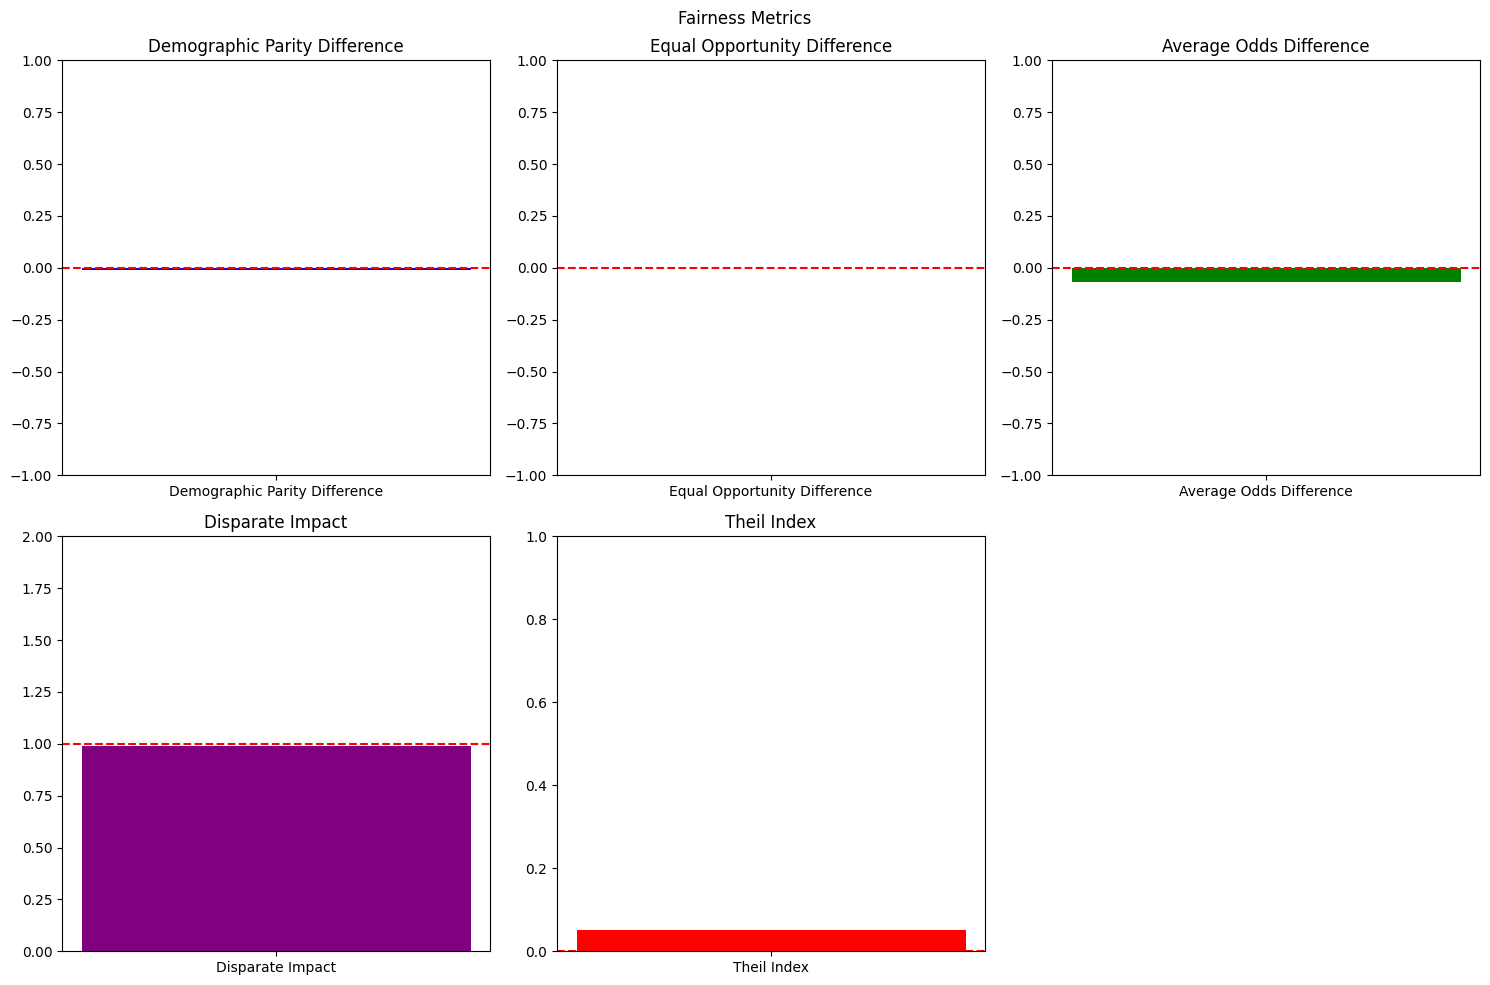

In [29]:
# Plot fairness metrics
plot_fairness_metrics(fairness_metrics)

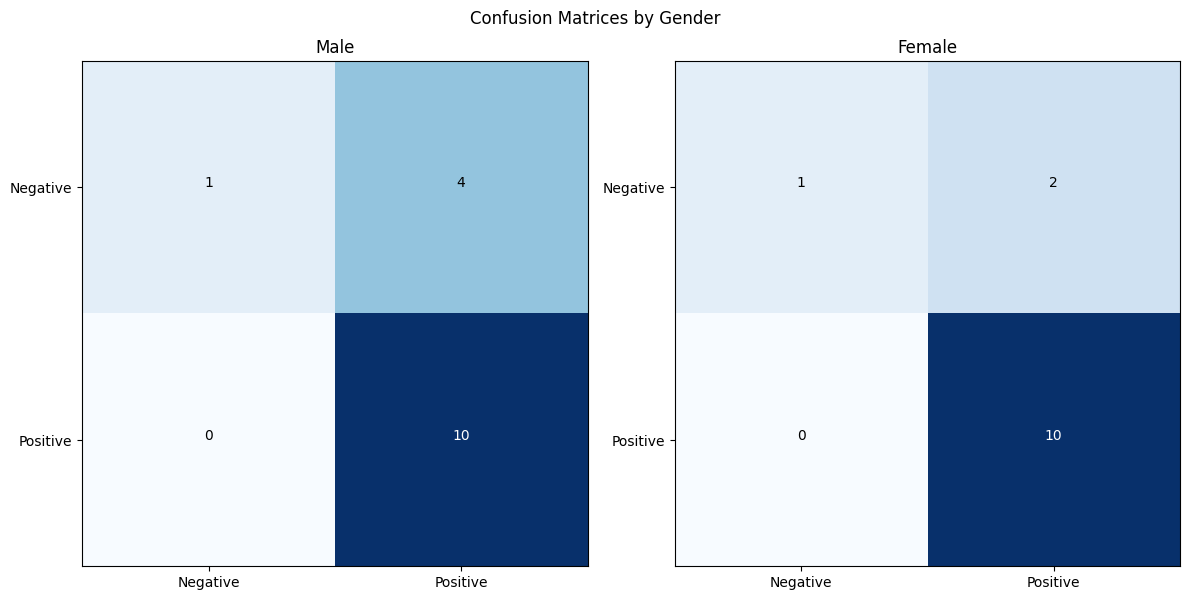

In [30]:
# Plot confusion matrices
plot_confusion_matrices(y_test.values, y_pred_xgb, X_test['gender'])

Bias Mitigation using Reweighing

We'll apply the Reweighing technique to mitigate bias and retrain the model.

In [31]:
# Apply reweighing
def apply_reweighing(X_train, y_train):
    binary_train = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1), label_names=['survival'], protected_attribute_names=['gender'])
    reweighing = Reweighing(unprivileged_groups=[{'gender': 0}], privileged_groups=[{'gender': 1}])
    binary_train_reweighed = reweighing.fit_transform(binary_train)
    return binary_train_reweighed.instance_weights

In [32]:
# Apply reweighing to mitigate bias
instance_weights = apply_reweighing(X_train, y_train)

In [33]:
# Train and evaluate models applying bias mitigation algorithm
def train_and_evaluate_models_bias_mitigate(X_train_scaled, y_train, X_test_scaled, y_test, instance_weights=None):
    # Random Forest
    model_rf = RandomForestClassifier(
        max_depth=3, 
        min_samples_leaf= 3, 
        min_samples_split=3, 
        n_estimators=100, 
        random_state=42
        )
    model_rf.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_rf = model_rf.predict(X_test_scaled)
    display(Markdown("### With Bias Mitigation"))
    display_perform_metrics(y_test, y_pred_rf, title='Random Forest')

    # XGBoost
    # Define the XGBoost parameters
    model_xgb = xgb.XGBClassifier(
        n_estimators=200,
        gamma=0.1,
        learning_rate=0.2,
        max_depth=6,
        min_child_weight=3,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
        )
    model_xgb.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_xgb = model_xgb.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_xgb, title= 'XGBoost')

    # Voting Classifier
    voting_clf = VotingClassifier(
        estimators=[('rf', model_rf), 
                    ('xgb', model_xgb)], 
                    voting='soft'
                    )
    voting_clf.fit(X_train_scaled, y_train, sample_weight=instance_weights)
    y_pred_voting = voting_clf.predict(X_test_scaled)
    display_perform_metrics(y_test, y_pred_voting, title='Voting Classifier')

    return model_rf, model_xgb, voting_clf, y_pred_rf, y_pred_xgb, y_pred_voting

In [34]:
# Train and evaluate models with reweighed data
model_rf_bm, model_xgb_bm, voting_clf_bm, y_pred_rf_bm, y_pred_xgb_bm, _ = train_and_evaluate_models_bias_mitigate(X_train_scaled, y_train, X_test_scaled, y_test, instance_weights)

### With Bias Mitigation

#### For Random Forest Model 

Accuracy: 0.71


#### Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

#### For XGBoost Model 

Accuracy: 0.75


#### XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.76      0.95      0.84        20

    accuracy                           0.75        28
   macro avg       0.71      0.60      0.60        28
weighted avg       0.73      0.75      0.71        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### For Voting Classifier Model 

Accuracy: 0.71


#### Voting Classifier Classification Report:

d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.71      1.00      0.83        20

    accuracy                           0.71        28
   macro avg       0.36      0.50      0.42        28
weighted avg       0.51      0.71      0.60        28



d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\BVaidya\Anaconda3\envs\aigov_pytorch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# Perform bias detection and evaluate fairness metrics
display(Markdown("### With Bias Mitigation"))

fairness_metrics_bm = perform_bias_detection(X_test, y_test, y_pred_xgb_bm)

### With Bias Mitigation

#### Gender Bias Analysis: 

Disparate Impact: 1.154


  No significant bias detected: The model predictions are balanced with respect to gender.

#### Fairness Metrics by Gender:

Demographic Parity Difference: 0.056
Equal Opportunity Difference: 0.100
Average Odds Difference: -0.017
Disparate Impact: 1.065
Theil Index: 0.088


In [36]:
# Plot comparative fairness metrics
def plot_comparative_fairness_metrics(fairness_metrics, fairness_metrics_bm):
    metrics = list(fairness_metrics.keys())
    values = list(fairness_metrics.values())
    values_bm = list(fairness_metrics_bm.values())

    groups = ['Original', 'Mitigated']
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Comparative Fairness Metrics')

    axs[0, 0].bar(groups, [values[0],values_bm[0]], color=['blue', 'orange'])
    axs[0, 0].set_ylim(-1, 1)
    axs[0, 0].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 0].set_title(metrics[0])

    axs[0, 1].bar(groups, [values[1],values_bm[1]], color=['blue', 'orange'])
    axs[0, 1].set_ylim(-1, 1)
    axs[0, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 1].set_title(metrics[1])

    axs[0, 2].bar(groups, [values[2],values_bm[2]], color=['blue', 'orange'])
    axs[0, 2].set_ylim(-1, 1)
    axs[0, 2].axhline(y=0.0, color='r', linestyle='--')
    axs[0, 2].set_title(metrics[2])

    axs[1, 0].bar(groups, [values[3],values_bm[3]], color=['blue', 'orange'])
    axs[1, 0].set_ylim(0, 2)
    axs[1, 0].axhline(y=1.0, color='r', linestyle='--')
    axs[1, 0].set_title(metrics[3])

    axs[1, 1].bar(groups, [values[4],values_bm[4]], color=['blue', 'orange'])
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].axhline(y=0.0, color='r', linestyle='--')
    axs[1, 1].set_title(metrics[4])

    fig.delaxes(axs[1, 2])  
    plt.tight_layout()
    plt.show()

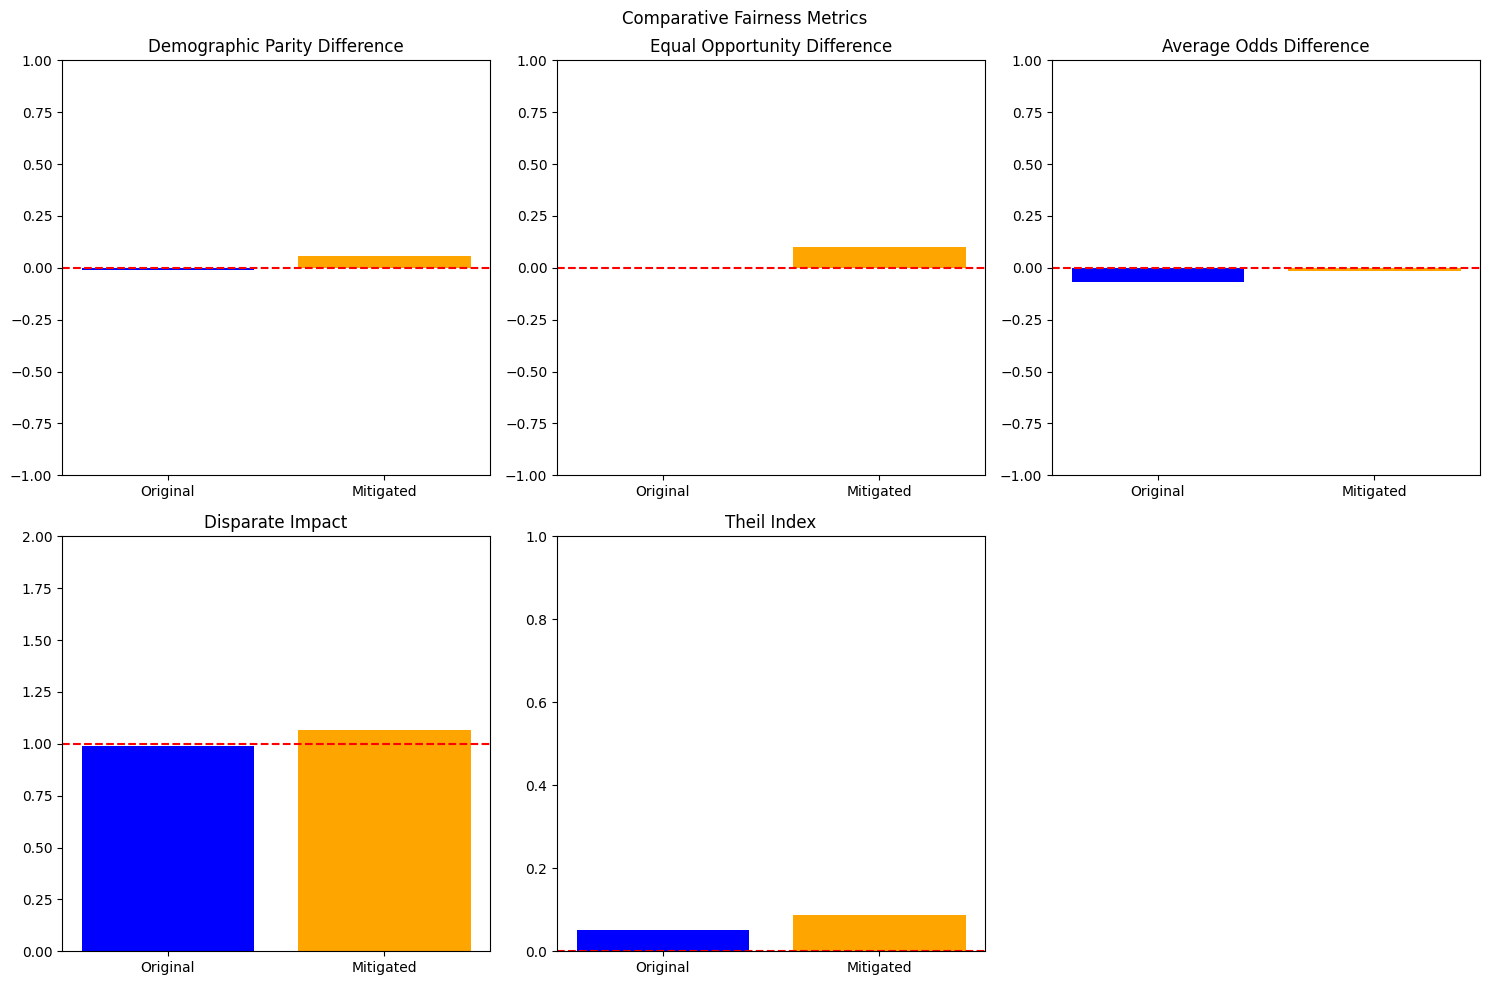

In [37]:
plot_comparative_fairness_metrics(fairness_metrics, fairness_metrics_bm)

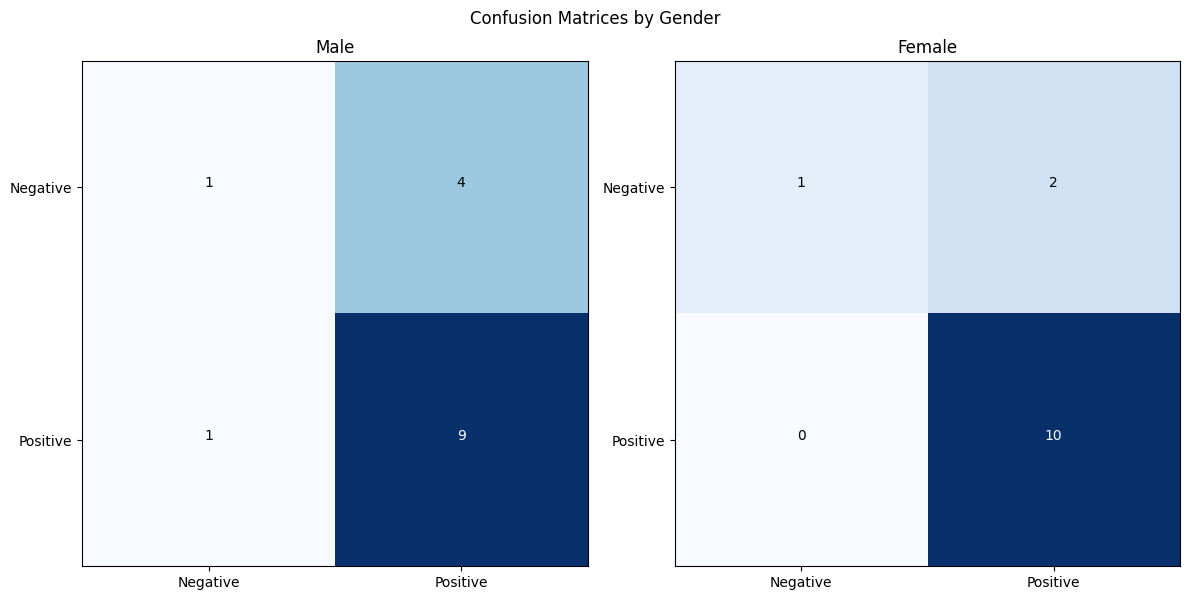

In [38]:
# Plot confusion matrices
plot_confusion_matrices(y_test.values, y_pred_xgb_bm, X_test['gender'])